In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader

from recycle_cnn import CNN
from recycle_resnet import ResNet, BasicBlock


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)
    
learning_rate = 0.0005
epochs = 15
batch_size = 32

In [3]:
trans = transforms.ToTensor()

train_set = torchvision.datasets.ImageFolder('data/train',transform=trans)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [4]:
valid_set = torchvision.datasets.ImageFolder('data/valid',transform=trans)
valid_loader = DataLoader(valid_set)

In [5]:
model = CNN().to(device)
# model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

In [6]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

total_batch = len(train_loader)


In [7]:
print(model)

CNN(
  (act): ReLU()
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [8]:
def train_one_epoch(data_loader):
    model.train()
    running_loss = 0
    total = 0
    correct = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = torch.max(outputs, 1)[1]
        correct += (preds == labels).sum()
        total += len(labels)
        running_loss += loss.detach()
        
    loss = (running_loss / len(data_loader)).item()
    accuracy = (correct * 100 / total).item()
    return loss, accuracy


In [9]:
def eval_one_epoch(data_loader):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = torch.max(outputs, 1)[1]
            correct += (preds == labels).sum()

            total += len(labels)
            running_loss += loss.detach()
        
        loss = (running_loss / len(data_loader)).item()
        accuracy = (correct * 100 / total).item()
        return loss, accuracy

In [10]:
train_loss_hist = []
train_acc_hist = []
valid_loss_hist = []
valid_acc_hist = [] 
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    valid_loss, valid_acc = eval_one_epoch(valid_loader)
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(valid_acc)
    print(f"Epoch: {epoch}\nTrain Loss: {train_loss_hist[-1]}, accuracy: {train_acc_hist[-1]}\n"+
        f"Valid loss: {valid_loss_hist[-1]}, accuracy: {valid_acc_hist[-1]}")


Epoch: 0
Train Loss: 4.6284098625183105, accuracy: 40.2714958190918
Valid loss: 1.5701662302017212, accuracy: 49.39024353027344
Epoch: 1
Train Loss: 1.820662260055542, accuracy: 54.128963470458984
Valid loss: 1.4531373977661133, accuracy: 57.92682647705078
Epoch: 2
Train Loss: 1.22825288772583, accuracy: 61.42534255981445
Valid loss: 2.084296226501465, accuracy: 43.90243911743164
Epoch: 3
Train Loss: 1.0489739179611206, accuracy: 67.08145141601562
Valid loss: 1.4877636432647705, accuracy: 56.097557067871094
Epoch: 4
Train Loss: 1.0000585317611694, accuracy: 68.6651611328125
Valid loss: 1.535834789276123, accuracy: 57.01219177246094
Epoch: 5
Train Loss: 0.8428905010223389, accuracy: 72.398193359375
Valid loss: 1.693219780921936, accuracy: 60.06097412109375
Epoch: 6
Train Loss: 0.6230665445327759, accuracy: 78.90271759033203
Valid loss: 1.4568202495574951, accuracy: 59.75609588623047
Epoch: 7
Train Loss: 0.49935659766197205, accuracy: 82.01358032226562
Valid loss: 1.4499297142028809, acc

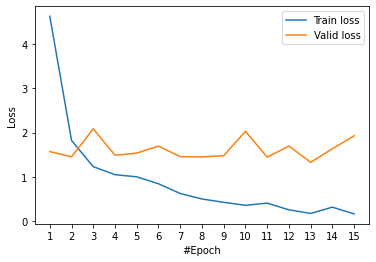

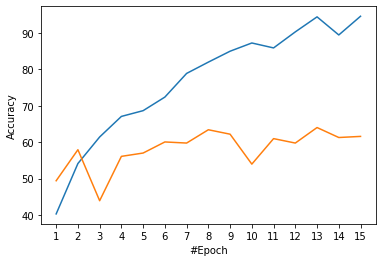

In [11]:
epochs = list(range(1, epochs + 1))
plt.plot(epochs, train_loss_hist, label='Train loss')
plt.plot(epochs, valid_loss_hist, label='Valid loss')
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.plot(epochs, train_acc_hist, label='Train accuracy')
plt.plot(epochs, valid_acc_hist, label='Valid accuracy')
plt.xlabel("#Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.show()


In [12]:
torch.save(model, 'model.pt')